In [63]:
%matplotlib inline

from matplotlib import pyplot as pl
from scipy.integrate import odeint
import numpy as np

# A solar system simulator demonstration in python

This notebook shows a simple solar system simulator (or in reality any general N-body gravitational interaction simulator) using python.

In [75]:
def grav(x, t, masses):
    """
    Coupled differential equations for computing the gravitational
    attraction between n-bodies.

    Args:
        x (:class:`numpy.ndarray`): an array containing the 3D position and velocity vectors of
            each of then bodies, e.g. for [x1, y1, z1, vx1, vy1, vz1, ... ]
        t (float): a time
        masses (list): a list of masses multiplied by G for each bodies, in units using AUs and
           days 
    """

    # number of bodies
    N = len(masses)

    Y = np.zeros(6*N)
    # coupled differential equations
    # x = [x,y,z,vx,vy,vz]

    # 3D orbits
    for i in range(N):
        # dx/dt = v
        Y[6*i:6*i+3] = x[6*i+3:6*i+6]

        for j in range(N):
            if i != j:
                r = np.sqrt(np.sum((x[6*j:6*j+3]-x[6*i:6*i+3])**2))

                # dv/dt = a  (a = F/m) (F = GMm|x2-x1|/r^3)
                Y[6*j+3:6*j+6] += masses[i]*(x[6*i:6*i+3]-x[6*j:6*j+3])/r**3         

    return Y

To initialise the solar system (positions and velocities), in this case just the Earth/Moon system and Sun, we can use the JPL ephemeris values (e.g., those found [here](http://www.astro.gla.ac.uk/honours/labs/solar_system/JPL%20coordinates/)). We also need masses of the planets, which are given as ratios to the mass of the Sun, which in turn is defined though the [Gaussian gravitational constant](https://en.wikipedia.org/wiki/Gaussian_gravitational_constant), [here](http://www.astro.gla.ac.uk/honours/labs/solar_system/astro_constants.html).

In [3]:
# set masses (Earth and Sun)
GM = [(0.01720209895)**2/328900.56, (0.01720209895)**2]  # see http://www.astro.gla.ac.uk/honours/labs/solar_system/astro_constants.html

# set up the initial position of the Earth in units of AU and AU/day:
X = np.zeros(2*6)

# Earth's initial position and velocity
X[0] = -1.756895992827094E-01
X[1] =  9.659716383076408E-01
X[2] = 2.050240276128469E-04
X[3] = -1.722463621150023E-02
X[4] = -3.020684839068507E-03
X[5] = -7.003389133678563E-08

# Sun's initial position and velocity
X[6] = -7.139147132286038E-03
X[7] = -2.792019830280757E-03
X[8] = 2.061825715444439E-04
X[9] = 5.374261407019511E-06
X[10] = -7.410966744915032E-06
X[11] = -9.422889366172143E-08

# set the timestamps at which the solver will work (note that this does not use adaptive step sizes)
times = np.arange(0., 3650.) # ten years with one step per day

y, infodict = odeint(grav, X, times, args=(GM,), full_output=True)


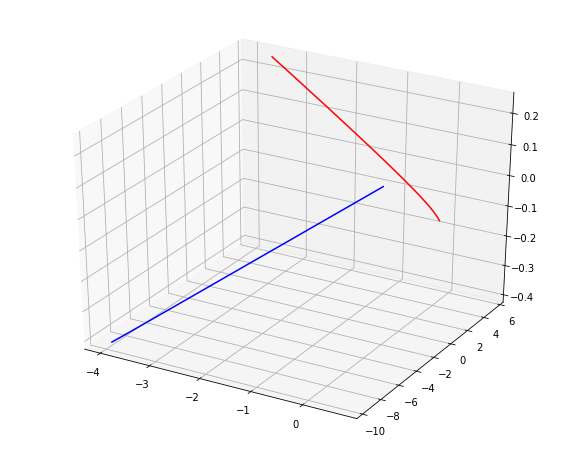

In [80]:
from mpl_toolkits.mplot3d import Axes3D

fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(y[:,0], y[:,1], y[:,2], 'b')
ax.plot(y[:,6], y[:,7], y[:,8], 'r')

Let's do all the planets!

In [64]:
import requests
from six import StringIO
import re
from collections import OrderedDict

In [76]:
# read in the JPL ephemeris data
baseurl = 'http://www.astro.gla.ac.uk/honours/labs/solar_system/JPL%20coordinates/{}'

jplfiles = OrderedDict() # use ordered dictionary so that planets are in the right order
jplfiles['Sun'] = 'sun.txt'
jplfiles['Mercury'] = 'mercury.txt'
jplfiles['Venus'] = 'venus.txt'
jplfiles['Earth'] = 'earthmoon.txt'
jplfiles['Mars'] = 'mars.txt'
jplfiles['Jupiter'] = 'jupiter.txt'
jplfiles['Saturn'] = 'saturn.txt'
jplfiles['Uranus'] = 'uranus.txt'
jplfiles['Neptune'] = 'neptune.txt'
jplfiles['Pluto'] = 'pluto.txt'

jpldata = OrderedDict()
for oname, ofile in jplfiles.items():
    jpleph = requests.get(baseurl.format(ofile))
    content = re.findall(r'\$\$SOE(.*?)\$\$EOE', str(jpleph.content), flags=re.U|re.S|re.M)[0]
    fp = StringIO(content)
    data = np.loadtxt(fp, delimiter=',', usecols=(0, 2, 3, 4, 5, 6, 7))
    jpldata[oname] = data

In [77]:
# mass ratios compared to the Sun
massratios = OrderedDict()
massratios['Sun'] =     1.
massratios['Mercury'] = 1./6023600.
massratios['Venus'] =   1./408523.71
massratios['Earth'] =   1./328900.56 # Earth + Moon system
massratios['Mars'] =    1./3098708.
massratios['Jupiter'] = 1./1047.3486
massratios['Saturn'] =  1./3497.898
massratios['Uranus'] =  1./22902.98
massratios['Neptune'] = 1./19412.24
massratios['Pluto'] =   1./1.35e8

# Gaussian gravitational constant
k = 0.01720209895 # (AU^3/d^2)^1/2

# G*M
GM = np.array(massratios.values())*k**2

In [8]:
# set up the initial position of the Earth in units of AU and AU/day:
X = np.zeros(len(GM)*6)
for i, planet in enumerate(jpldata.keys()):
    X[6*i:6*(i+1)] = jpldata[planet][0,1:]

times = jpldata['Sun'][:,0]-jpldata['Sun'][0,0]

y, infodict = odeint(grav, X, times, args=(GM,), full_output=True)

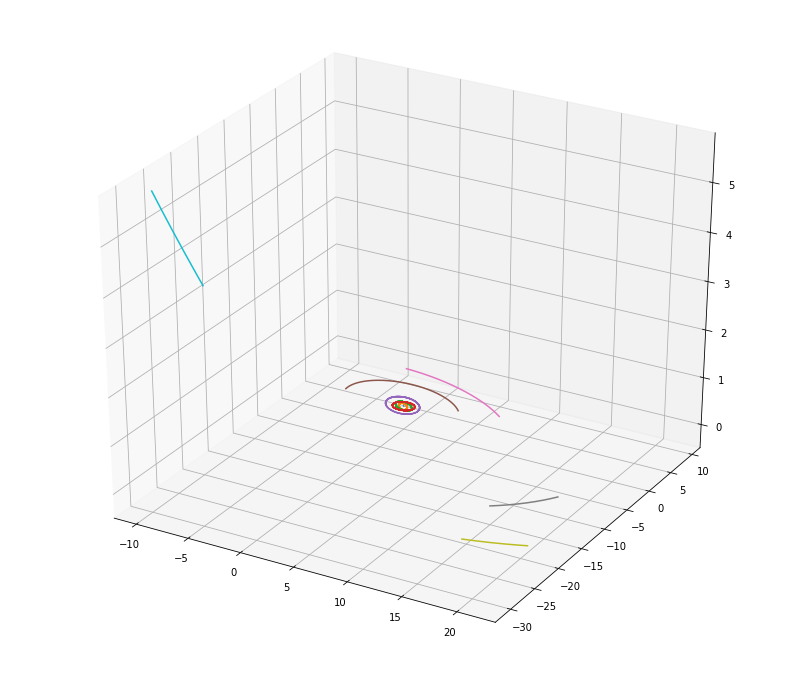

In [9]:
fig = pl.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(GM)):
    ax.plot(y[:,6*i], y[:,6*i+1], y[:,6*i+2])

Now we'll use try using [astropy](http://docs.astropy.org/en/stable/) (which itself uses [jplephem](https://pypi.python.org/pypi/jplephem)) to get solar system ephemeris values, so both these packages should be installed using, e.g,

```bash
pip install astropy
pip install jplephem
```

> Note: this requires astropy v. 2.0.3

To convert between equatorial coordinates returned by jplephem and ecliptic coordinates used in the solar system simulator we need to install [spicepy](http://spiceypy.readthedocs.io).

In [82]:
from astropy.coordinates import get_body_barycentric_posvel # function to get positions and velocities
from astropy.time import Time, TimeDelta
from astropy.coordinates import solar_system_ephemeris
from astropy import units as u

from spiceypy import sxform, mxvg

# some URLs for different ephemerides (these will be downloaded and cached on first use)
ephurls = {'de432s': 'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de432s.bsp',
           'de430': 'http://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de430.bsp',
           'de200': 'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de200.bsp',
           'de405': 'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de405.bsp',
           'de406s': 'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de406s.bsp',
           'de410': 'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de410.bsp',
           'de421': 'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de421.bsp'}

#starttime = Time('2000-01-01 00:00:00.00')
#starttime = Time('2000-01-01 00:00:00.00', scale='tdb')
starttime = Time(2451544.5, format='jd', scale='tdb')

# time step of 10 days
#dt = TimeDelta(10.0, format='jd', scale='tai')
dt = TimeDelta(10.0, format='jd', scale='tdb')

# 3650 days
nsteps = 365

# the ephemerides in http://www.astro.gla.ac.uk/honours/labs/solar_system/JPL%20coordinates come from DE406,
# but we'll use the more up-to-date DE430

#eph = 'de406s'
#eph = 'de405'
eph = 'de430'
solar_system_ephemeris.set(ephurls[eph])

# print out the available bodies
print(solar_system_ephemeris.bodies)

bodies = ['sun', 'mercury', 'venus', 'earth-moon-barycenter', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune', 'pluto']

ephemdata = OrderedDict()

for body in bodies:
    poseq = []  # positions in equatorial plane
    veleq = []  # velocities in equatorial plane
    posecl = [] # positions in ecliptic plane
    velecl = [] # velocities in ecliptic plane

    curtime = starttime

    for i in range(nsteps):
        tpos, tvel = get_body_barycentric_posvel(body, curtime)
        # convert (equatorial) positions into AU
        poseq.append(tpos.xyz)
    
        # convert (equatorial) velocities into AU/day
        veleq.append(tvel.xyz)
    
        # get equatorial state vector
        statevec = [poseq[-1][0].value, poseq[-1][1].value, poseq[-1][2].value,
                    veleq[-1][0].value, veleq[-1][1].value, veleq[-1][2].value]
    
        # get transformation matrix
        trans = sxform("J2000", "ECLIPJ2000", curtime.value)
    
        # transform state vector to ecliptic
        statevececl = mxvg(trans, statevec, 6, 6)
    
        posecl.append([statevececl[0]*u.km, statevececl[1]*u.km, statevececl[2]*u.km])
        velecl.append([statevececl[3]*u.km/u.d, statevececl[4]*u.km/u.d, statevececl[5]*u.km/u.d])
    
        curtime += dt
    
    ephemdata[body] = np.hstack((np.array([[pv[0].to('AU').value, pv[1].to('AU').value, pv[2].to('AU').value] for pv in posecl]),
                                 np.array([[pv[0].to('AU/d').value, pv[1].to('AU/d').value, pv[2].to('AU/d').value] for pv in velecl])))

(u'sun', u'mercury', u'venus', u'earth-moon-barycenter', u'earth', u'moon', u'mars', u'jupiter', u'saturn', u'uranus', u'neptune', u'pluto')


In [83]:
# set up the initial position of the Earth in units of AU and AU/day:
X = np.zeros(len(GM)*6)
for i, planet in enumerate(bodies):
    X[6*i:6*(i+1)] = ephemdata[planet][0,:]

times = np.arange(0., 365., 10)

y, infodict = odeint(grav, X, times, args=(GM,), full_output=True)

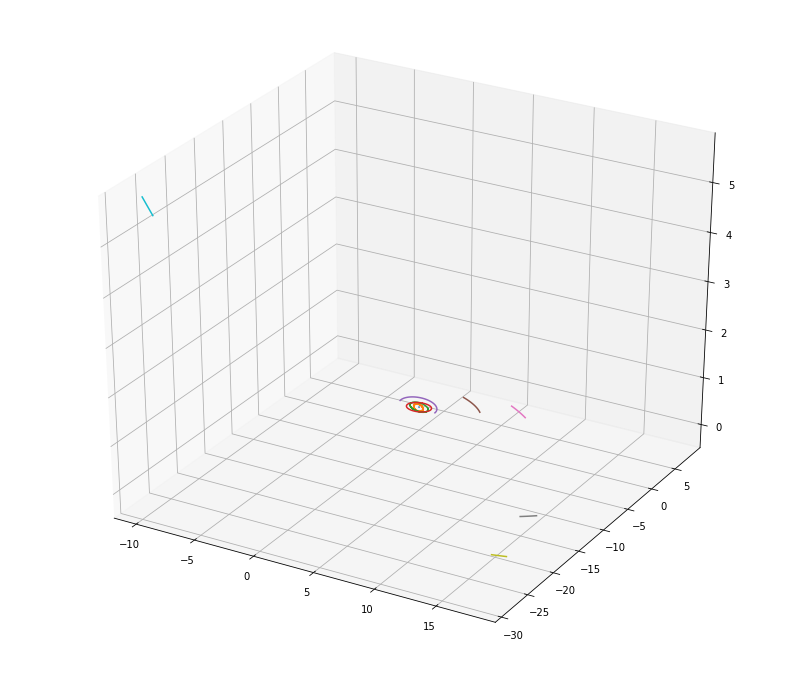

In [84]:
fig = pl.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(GM)):
    ax.plot(y[:,6*i], y[:,6*i+1], y[:,6*i+2])